In [1]:
import pandas as pd

In [38]:
good_data = pd.read_csv("good_data.csv", header=None)
shuffled_data = pd.read_csv("bad_data_shuffle_pair.csv", header=None)

good_data.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [39]:
good_data_marked = good_data.assign(correct=lambda _: 1)
shuffled_data_marked = shuffled_data.assign(correct=lambda _: 0)
joined_data = good_data_marked.append(shuffled_data_marked)

In [40]:
joined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,correct
0,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
2,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [41]:
joined_data = joined_data.sample(frac=1).reset_index(drop=True) #shuffle data in place
joined_data.head()

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,correct
0,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1


In [42]:
Y = joined_data.pop('correct')

In [2]:
import numpy as np

In [55]:
# takes 1+ hour to process all data
# in future consider creating data already in propre format
joined_data_final= np.array([
    np.array(np.array_split(row, 200)) for index, row in joined_data.iterrows()
])

joined_data_final.shape

(90266, 200, 4)

In [57]:
#saving
import pickle
output = open('data2_200x4.pkl', 'wb')
pickle.dump(joined_data_final, output)
output.close()

output = open('y2_200x4.pkl', 'wb')
pickle.dump(Y, output)
output.close()

In [3]:
# loading
import pickle
pkl_file = open('data2_200x4.pkl.pkl', 'rb')
joined_data_final = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('y2_200x4.pkl', 'rb')
Y = pickle.load(pkl_file)
pkl_file.close()


In [58]:
joined_data_final.shape, Y.shape

((90266, 200, 4), (90266,))

In [59]:
X_test = joined_data_final[:18053]
X_valid = joined_data_final[18053:(18053*2)]
X_train = joined_data_final[(18053*2):]

In [60]:
Y_test = Y[:18053]
Y_valid = Y[18053:(18053*2)]
Y_train = Y[(18053*2):]
Y_train.head()

36106    1
36107    0
36108    1
36109    0
36110    0
Name: correct, dtype: int64

In [13]:
import tensorflow as tf
from tensorflow import keras

In [62]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=100, kernel_size=4, strides=2, activation='relu', padding="same", input_shape=(200, 4)))
model.add(keras.layers.Conv1D(filters=100, kernel_size=4, activation='relu', padding="same"))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=200, kernel_size=2, strides=2, activation='relu', padding="same"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 100, 100)          1700      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 100)          40100     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 100)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 25, 200)           40200     
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               1500300   
_________________________________________________________________
dense_13 (Dense)             (None, 300)              

In [63]:
model.compile(
    loss="binary_crossentropy",
    optimizer="sgd",
    metrics=["binary_accuracy"])

In [64]:
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=0, 
    mode='auto'
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_pairs2.h5",save_best_only=True)

In [65]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), callbacks=[es, checkpoint_cb])

Train on 54160 samples, validate on 18053 samples
Epoch 1/25
54160/54160 [==============================] - 38s 696us/sample - loss: 0.6918 - binary_accuracy: 0.5234 - val_loss: 0.6891 - val_binary_accuracy: 0.5314
Epoch 2/25
54160/54160 [==============================] - 32s 597us/sample - loss: 0.6533 - binary_accuracy: 0.6353 - val_loss: 0.5265 - val_binary_accuracy: 0.7443
Epoch 3/25
54160/54160 [==============================] - 32s 595us/sample - loss: 0.3591 - binary_accuracy: 0.8415 - val_loss: 0.2721 - val_binary_accuracy: 0.8869
Epoch 4/25
54160/54160 [==============================] - 31s 576us/sample - loss: 0.2676 - binary_accuracy: 0.8910 - val_loss: 0.3331 - val_binary_accuracy: 0.8572
Epoch 5/25
54160/54160 [==============================] - 31s 565us/sample - loss: 0.2515 - binary_accuracy: 0.8973 - val_loss: 0.2774 - val_binary_accuracy: 0.8842
Epoch 6/25
54160/54160 [==============================] - 31s 572us/sample - loss: 0.2438 - binary_accuracy: 0.9003 - val_los

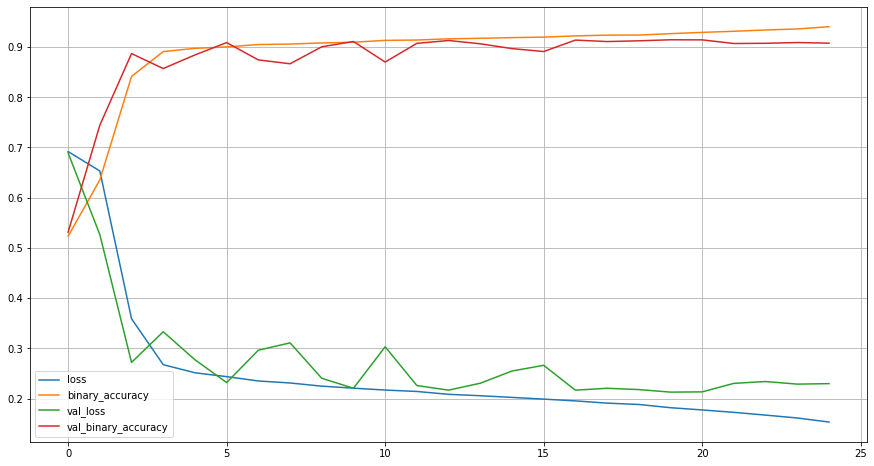

In [66]:
plt = pd.DataFrame(history.history).plot(figsize=(15, 8))
plt.grid(True)

In [67]:
X_test.shape

(18053, 200, 4)

In [68]:
model2 = keras.models.load_model("best_model_pairs2.h5")
model2.evaluate(X_test, Y_test)

18053/18053 [==============================] - 4s 219us/sample - loss: 0.2082 - binary_accuracy: 0.9167


[0.2081934700947052, 0.91668975]

In [85]:
model2.weights[0].shape

TensorShape([4, 4, 100])

In [87]:
model2.get_weights()[0][0][0]

array([ 0.02981699, -0.04706142, -0.07814998,  0.11168502, -0.08674326,
       -0.03579116, -0.04380981,  0.04455589,  0.00098804, -0.25900683,
        0.07938333, -0.12531324, -0.08148261,  0.10993794,  0.14506035,
       -0.11127324,  0.15852836, -0.05782003,  0.06191642,  0.03160987,
       -0.06286087,  0.05228719, -0.09307738, -0.2785757 ,  0.09218462,
        0.08084708, -0.1291546 , -0.07598386, -0.01470486, -0.09162509,
        0.04674182, -0.11806038, -0.05676213,  0.14278336, -0.13578492,
        0.10656637, -0.03461863,  0.05940049, -0.0404891 , -0.0154265 ,
       -0.06438208,  0.01930941,  0.09827557, -0.07093679,  0.08185898,
        0.05453931, -0.06008158,  0.21128555, -0.24997395, -0.29726386,
        0.08100201, -0.26229087, -0.00512317,  0.0924891 , -0.08265042,
       -0.22376145, -0.04803211, -0.05124462, -0.03111094, -0.07746024,
        0.00119501,  0.08748472, -0.12790476,  0.01775588, -0.10246626,
       -0.12296022, -0.02634753, -0.05968617,  0.02425276, -0.10

In [92]:
from PIL import Image
#checkout https://github.com/keplr-io/quiver
from matplotlib import cm
from sklearn.preprocessing import minmax_scale

In [131]:
model2.get_weights()[0].shape

(4, 4, 100)

In [132]:
weights = minmax_scale(model2.get_weights()[0][0]) #rescale weights to <0,1>
colors = np.uint8(cm.gist_heat(weights)*255)
colors[0]

ValueError: Found array with dim 3. Estimator expected <= 2.

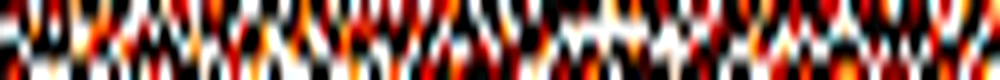

In [128]:
im = Image.fromarray(colors)
im.resize((im.size[0]*10,im.size[1]*20), Image.ANTIALIAS)

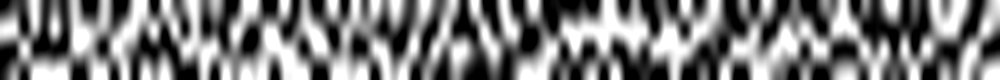

In [126]:
img = Image.fromarray(np.uint8(weights*255))
img.resize((im.size[0]*10,im.size[1]*20), Image.ANTIALIAS)